In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
     

In [2]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 98% 145M/149M [00:04<00:00, 42.8MB/s]
100% 149M/149M [00:04<00:00, 34.2MB/s]


In [3]:
!unzip -qq brain-tumor-mri-dataset.zip

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils    
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

In [5]:
batch_size=32
image_size = 240

In [6]:
imagePaths = "Training"
test_path="Testing"    

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  #seed=123,
  image_size=(image_size, image_size),
  #label_mode="categorical",
  batch_size=batch_size)

Found 1311 files belonging to 4 classes.


In [12]:
from tensorflow.keras.applications import EfficientNetB1

In [13]:
from tensorflow.keras.models import Model

In [14]:
effnet = EfficientNetB1(weights='imagenet', 
                        include_top=False, 
                        input_shape=(240, 240, 3))

27018416/27018416 [==============================] - 1s 0us/step


In [15]:
model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, 
              outputs=model)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 240, 240, 3)  0           ['normalization[0][0]']      

In [17]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))
     

In [18]:
y_train= tf.concat([y for x, y in train_ds], axis=0)

In [19]:
class_weights = generate_class_weights(y_train.numpy())

In [20]:
class_weights

{0: 1.048165137614679,
 1: 1.0964491362763915,
 2: 0.8967817896389325,
 3: 0.9815292096219931}

In [26]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [29]:
def get_early_stopping():
    
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [30]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=6, min_lr=0.000001)

checkpoint_filepath = "./checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
)

early_stopping = get_early_stopping()

callbacks = [checkpoint_callback, early_stopping, reduce_lr]

In [31]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=30,
                    class_weight=class_weights, callbacks=callbacks)

Epoch 1/30
143/143 [==============================] - 126s 480ms/step - loss: 0.1544 - accuracy: 0.9530 - val_loss: 1.5644 - val_accuracy: 0.8520 - lr: 0.0010
Epoch 2/30
143/143 [==============================] - 67s 464ms/step - loss: 0.0665 - accuracy: 0.9783 - val_loss: 0.3621 - val_accuracy: 0.9221 - lr: 0.0010
Epoch 3/30
143/143 [==============================] - 65s 455ms/step - loss: 0.0818 - accuracy: 0.9737 - val_loss: 0.3786 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 4/30
143/143 [==============================] - 67s 465ms/step - loss: 0.0474 - accuracy: 0.9849 - val_loss: 0.1794 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 5/30
143/143 [==============================] - 68s 476ms/step - loss: 0.0254 - accuracy: 0.9917 - val_loss: 0.0560 - val_accuracy: 0.9799 - lr: 0.0010
Epoch 6/30
143/143 [==============================] - 65s 455ms/step - loss: 0.0351 - accuracy: 0.9902 - val_loss: 0.0889 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 7/30
143/143 [==============================]

In [32]:
model.load_weights(checkpoint_filepath)

In [33]:
model.evaluate(test_ds)

41/41 [==============================] - 6s 127ms/step - loss: 0.0333 - accuracy: 0.9886


[0.03330844268202782, 0.9885583519935608]

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 2s 2s/step


In [36]:
classes=['glioma','meningioma', 'notumor','pituitary']

[[291   9   0   0]
 [  1 304   1   0]
 [  0   1 404   0]
 [  0   3   0 297]]


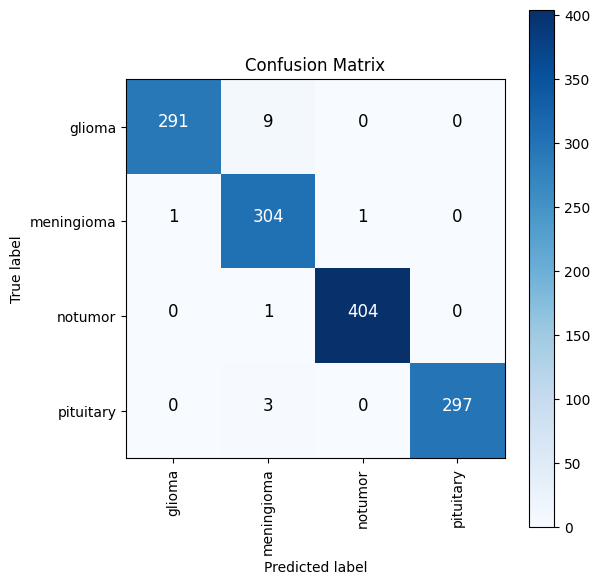

In [37]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [38]:
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       300
  meningioma       0.96      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [55]:
import tensorflow.keras as K

In [56]:
last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
last_conv_layer.name

'top_conv'

In [58]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

In [59]:
def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap


1/1 [==============================] - 1s 649ms/step


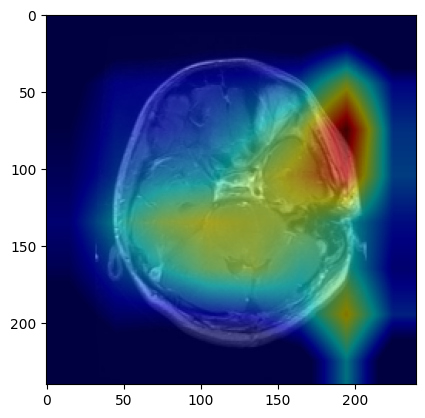

In [61]:
#load image
test_img = cv2.imread("/content/Testing/glioma/Te-gl_0010.jpg")
test_img = cv2.resize(test_img, (240, 240)) 

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)

1/1 [==============================] - 0s 50ms/step


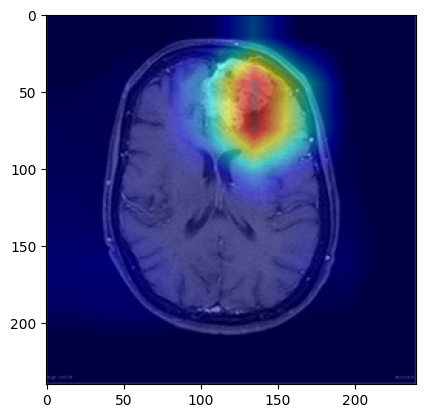

In [62]:
#load image
test_img = cv2.imread("/content/Testing/meningioma/Te-me_0033.jpg")
test_img = cv2.resize(test_img, (240, 240)) 

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)

1/1 [==============================] - 0s 47ms/step


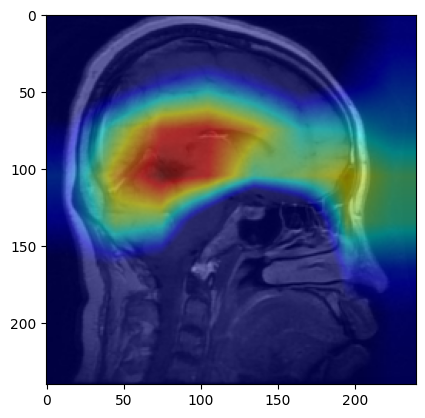

In [63]:
#load image
test_img = cv2.imread("/content/Testing/pituitary/Te-pi_0105.jpg")
test_img = cv2.resize(test_img, (240, 240)) 

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)

1/1 [==============================] - 0s 34ms/step


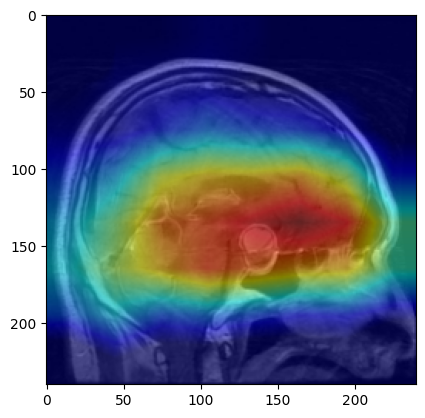

In [64]:
#load image
test_img = cv2.imread("/content/Testing/pituitary/Te-pi_0290.jpg")
test_img = cv2.resize(test_img, (240, 240)) 

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)

1/1 [==============================] - 0s 52ms/step


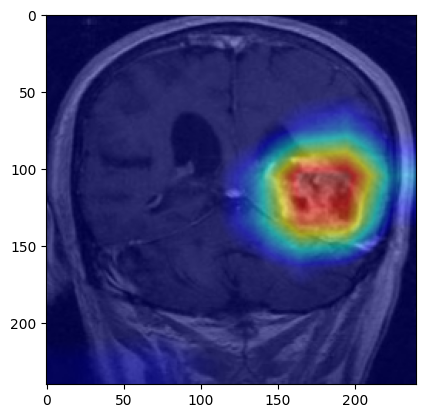

In [67]:
#load image
test_img = cv2.imread("/content/Testing/meningioma/Te-meTr_0007.jpg")
test_img = cv2.resize(test_img, (240, 240)) 

#apply function
VizGradCAM(model, img_to_array(test_img), plot_results=True)